In [ ]:
#Read intensity profiles exported as .csv from image J, nomalize distance, and divide intensity values by separately determined normalizarion constant
#Then ouptput  summary for all files in folder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# Set the folder path
folder_path = 'C:\\Users\\Sriram Sudarsanam\\Downloads\\Kolodkin lab\\Mef2c\\Luis Analysis\\P42 Plot profile\\Control BF'
folder_name = os.path.basename(folder_path)

# Create the base 'Distance' column with values from 0 to 1 in intervals of 0.1
distances = np.arange(0.1, 1.1, 0.1)  # Starting from 0.1 to match intervals (d - 0.1, d]
Df2 = pd.DataFrame({'Normalized Pia-WM Distance': distances})

# Loop over each .csv file in the specified folder
for file_path in glob.glob(os.path.join(folder_path, '*.csv')):
    # Read the current CSV file
    df = pd.read_csv(file_path)
    
    # Get the last value in the first column
    last_value = df.iloc[-1, 0]

    # Create a new column 'Norm Dist' with the divided values
    df['Norm Dist'] = df.iloc[:, 0] / last_value

    # Prompt the user for a constant
    IpsiInt = float(input(f"Enter the ipsilateral cell body intensity for {os.path.basename(file_path)}: "))

    # Create a new column 'Norm Int' with values from the second column divided by the constant
    df['Norm Int'] = df.iloc[:, 1] / IpsiInt

    # Calculate norm_int_sum over intervals for the current file
    norm_int_sum = [
        df.loc[(df['Norm Dist'] > d - 0.1) & (df['Norm Dist'] <= d), 'Norm Int'].sum()
        for d in distances
    ]

    # Add a new column to Df2 with the filename (without extension) as the header
    filename = os.path.splitext(os.path.basename(file_path))[0]
    Df2[filename] = norm_int_sum

# Calculate mean and standard deviation of each row, excluding the first column ('Distance')
Df2['Normalized Mean Intensity'] = Df2.iloc[:, 1:].mean(axis=1)
Df2['Std Dev'] = Df2.iloc[:, 1:].std(axis=1)

# Save Df2 as a .csv file
output_path = os.path.join(folder_path, f'Summary_{folder_name}_Profile.csv')
Df2.to_csv(output_path, index=False)



Please select the control CSV file.
Please select the treatment CSV file.


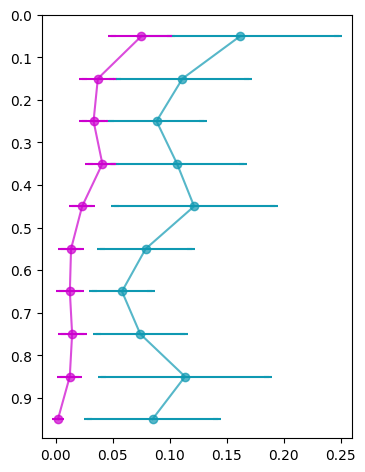

In [ ]:
#Seclect two .csv summary files of multiple intensity profiles and make a scatter plot of mean and s.d

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tkinter import Tk, filedialog
import os

# Function to prompt for a CSV file
def prompt_for_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    root.destroy()
    return file_path

# Prompt for the two CSV files
print("Please select the control CSV file.")
file1_path = prompt_for_file()
print("Please select the treatment CSV file.")
file2_path = prompt_for_file()

# Extract labels based on the filename portion between underscores
file1_name = os.path.basename(file1_path).split('_')
label1 = file1_name[1] if len(file1_name) > 2 else 'File 1'

file2_name = os.path.basename(file2_path).split('_')
label2 = file2_name[1] if len(file2_name) > 2 else 'File 2'
# Load the data from each file
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Extract the 'Normalized Pia-WM Distance', 'Normalized Mean Intensity', and 'Std Dev' columns
# Get the 'Normalized Pia-WM Distance' column
pia_wm_values = df1['Normalized Pia-WM Distance'].values

# Initialize the y1 list with the first value as the midpoint between 0 and the first value
y1 = [(pia_wm_values[0] + 0) / 2]  # Midpoint between 0 and the first value

# Compute the mean of consecutive values for the rest of y1
for i in range(1, len(pia_wm_values)):
    y1.append((pia_wm_values[i-1] + pia_wm_values[i]) / 2)

# Convert y1 to a numpy array if needed
y1 = np.array(y1)

x1 = df1['Normalized Mean Intensity']   
std_dev1 = df1['Std Dev']

x2 = df2['Normalized Mean Intensity']   
std_dev2 = df2['Std Dev']

# Plot settings
plt.figure(figsize=(4, 5.5))

# Scatter plot for the first CSV file with standard deviation error bars (darker cyan)
darker_cyan = '#0F99B2'  # Dark Cyan, matches prism
plt.scatter(x1, y1, color=darker_cyan, label=label1, alpha=0.7)
plt.plot(x1, y1, color=darker_cyan, linestyle='-', linewidth=1.5, alpha=0.7)  # Line connecting points 
for xi, yi, sdi in zip(x1, y1, std_dev1):
    plt.plot([xi - sdi, xi + sdi], [yi, yi], color=darker_cyan, linestyle='-', linewidth=1.5)  # Horizontal error bar
    plt.scatter([xi - sdi], [yi], color=darker_cyan, marker='_')
    plt.scatter([xi + sdi], [yi], color=darker_cyan, marker='_')

# Scatter plot for the second CSV file with standard deviation error bars
magenta = '#CC00CE'  # Darker magenta, matches prism
plt.scatter(x2, y1, color=magenta, label=label2, alpha=0.7)
plt.plot(x2, y1, color=magenta, linestyle='-', linewidth=1.5, alpha=0.7)  # Line connecting points
for xi, yi, sdi in zip(x2, y1, std_dev2):
    plt.plot([xi - sdi, xi + sdi], [yi, yi], color=magenta, linestyle='-', linewidth=1.5)  # Horizontal error bar
    plt.scatter([xi - sdi], [yi], color=magenta, marker='_')
    plt.scatter([xi + sdi], [yi], color=magenta, marker='_')

# Invert the y-axis if required
plt.gca().invert_yaxis()

# Labels and title- not applied here
#plt.ylabel('Normalized Pia-WM Distance')
#plt.xlabel('Normalized Mean Axon Intensity (a.u)')
#plt.title('Inneravation profile, cS1-S2')
# Display legend outside the plot area, in the top-right corner
#plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), frameon=False)
# Set y-axis ticks manually
plt.yticks(np.arange(0, 1.0, 0.1))  # Set tick interval to 0.1
plt.grid(False)
plt.show()

In [ ]:
#Run statistical test at each interval in plot profile- Mann Whitney; Bonferroni correction for multiple comparisons
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, levene
from tkinter import Tk, filedialog
import os

# Function to prompt for a CSV file
def prompt_for_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    root.destroy()
    return file_path

# Prompt for the CSV files
print("Please select the control csv file.")
file_path = prompt_for_file()
file_name = os.path.basename(file_path)
folder_path = os.path.dirname(file_path)
#Read csv file
data = pd.read_csv(file_path)  

# Separate location, control, and treatment data
locations = data['Location']
control_columns = [col for col in data.columns if "Control" in col]
treatment_columns = [col for col in data.columns if "Treatment" in col]

results = []  # To store results

# Perform tests for each location
for i, location in enumerate(locations):
    control_values = data.loc[i, control_columns].values
    treatment_values = data.loc[i, treatment_columns].values

    stat, p_value = mannwhitneyu(control_values, treatment_values, alternative='two-sided')
    test_used = "Mann-Whitney U"

    # Store results
    results.append({
        'Location': location,
        'Test': test_used,
        'Statistic': stat,
        'p-value': p_value
    })

# Adjust for multiple comparisons (Bonferroni correction)
adjusted_p_values = [res['p-value'] * len(locations) for res in results]
for res, adj_p in zip(results, adjusted_p_values):
    res['Adjusted p-value'] = min(adj_p, 1.0)  # P-values can't exceed 1

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
# Save results as a .csv file
output_path = os.path.join(folder_path, f'{file_name}_pValues.csv')
results_df.to_csv(output_path, index=False)
# Filter significant results
significant_results = results_df[results_df['Adjusted p-value'] < 0.05]
print("Significant Locations:\n", significant_results)

Please select the control csv file.
Significant Locations:
    Location    Test  Statistic   p-value  Adjusted p-value
8      0.85  t-test   4.451171  0.000977          0.009768
